In [1]:
from neo4j import GraphDatabase
from py2neo import Graph
import pandas as pd
import numpy as np
import ast
import time
import os
from collections import defaultdict
from requests.exceptions import HTTPError
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import requests
import xgboost as xgb
import joblib
from datetime import datetime
from sklearn.pipeline import Pipeline
import threading
import queue
import json
import matplotlib.pyplot as plt

## Start tor (cmd)
- tor.exe -f "C:\Users\alema\Desktop\Tor Browser\Browser\TorBrowser\Data\Tor\torrc"

In [2]:
from utils import get_statistics
from stem.control import Controller
from stem import Signal
import socks
import socket

In [2]:
with open("data_split/new_dst_labels/LABELS_merged.json", "r") as file:
    labels_dict = json.load(file)

In [4]:
scraping = pd.read_csv('data_split/new_dst_labels/address_scraping.csv')

In [2]:
def load_csv(file_path):
    df = pd.read_csv(file_path)#.drop(columns=['Unnamed: 0'])
    df['src'] = df['src'].apply(ast.literal_eval)
    df['dst'] = df['dst'].apply(ast.literal_eval)
    df['values_in'] = df['values_in'].apply(ast.literal_eval)
    df['values_out'] = df['values_out'].apply(ast.literal_eval)
    df['scripts'] = df['scripts'].apply(ast.literal_eval)
    return df

## SCRAPING

In [5]:
def to_btc(n):
    formatted_n = n / 100000000
    return formatted_n

In [6]:
def recognize_script(tokens):
        if len(tokens) == 5 and tokens[0] == "76" and tokens[1] == "a9" and tokens[3] == "88" and tokens[4] == "ac":
            return "P2PKH"
        elif len(tokens) == 3 and tokens[0] == "a9" and tokens[2] == "87":
            return "P2SH"
        elif len(tokens) == 2 and tokens[0] == "00" and len(tokens[1]) == 40:  
            return "P2WPKH"
        elif len(tokens) == 2 and tokens[0] == "00" and len(tokens[1]) == 64: 
            return "P2WSH"
        else:
            return "Unknown"
            
def parse_script(script_hex):
    OPCODES = {
        "76": "OP_DUP",
        "a9": "OP_HASH160",
        "88": "OP_EQUALVERIFY",
        "ac": "OP_CHECKSIG",
        "00": "OP_0",
    }

    i = 0
    tokens = []
    while i < len(script_hex):
        opcode = script_hex[i:i+2]
        if opcode in OPCODES:
            tokens.append(opcode)  # Opcode
            i += 2
        else:
            data_length = int(opcode, 16)
            data = script_hex[i+2:i+2+data_length*2]
            tokens.append(data)
            i += 2 + data_length * 2


    script_type = recognize_script(tokens)
    return script_type

In [8]:
controller = Controller.from_port(port=9051)

def connectTor():
    socks.setdefaultproxy(socks.PROXY_TYPE_SOCKS5, "127.0.0.1", 9050, True)
    socket.socket = socks.socksocket

def renewTor():
    controller.authenticate("your_password")
    controller.signal(Signal.NEWNYM)

In [7]:
def get_explorer_data(address): #SEEDS
    retries = 0
    delay = 10
    url = f"https://blockchain.info/rawaddr/{address}" 
    
    out_txs = []
    while True:#retries < 5:
        try:
            renewTor()
            connectTor()
            time.sleep(10)
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            break
        except HTTPError as http_err:
            if response.status_code == 429:  # Too Many Requests
                time.sleep(delay) 
                retries += 1
                #print(f"{http_err}")
            else:
                print(f"HTTP error occurred: {http_err}")
                time.sleep(1)
                retries += 1
        except Exception as err:
            print(f"Generic error: {err}")
            time.sleep(1)
            retries += 1
    
    #Filter only outgoing txs
    c_in_txs = 0
    for tx in data['txs']:
        if tx['result'] < 0:
            out_txs += [tx]
        else:
            c_in_txs += 1
    data['txs'] = out_txs
    
    return data, c_in_txs

In [8]:
def get_last_txs(address):
    n = 250
    data, c_in_tx = get_explorer_data(address)
    offset = 0
    while((len(data['txs']) + c_in_tx) < data['n_tx']) and (len(data['txs']) < n) :
        offset = len(data['txs']) + c_in_tx
        tmp, tmp_c_in_tx = get_explorer_data(f"{address}?&offset={offset}&limit={abs(len(data['txs']) - n)}")
        c_in_tx += tmp_c_in_tx
        data['txs'] = data['txs'] + tmp['txs']
    data['txs'].reverse()
    return data['txs']

In [9]:
def build_block(txs):
    for tx in txs:
        
        fee = to_btc(tx['fee'])
        txid = tx['hash']
        timestamp = tx['time']

        addr_ins = []
        val_ins = []
        addr_outs = []
        val_outs =  []
        scripts = []

        addr_uses = 0
        tot_value = 0
        sender_value = 0

        ins = tx['inputs']
        for el in ins:
            try:
                addr = el['prev_out']['addr']
            except KeyError as ke:
                addr = 'Unknown'
                #print('Unknown address among outputs')
            addr_ins.append(addr)
            val_ins.append(to_btc(el['prev_out']['value']))
            
        out = tx['out']
        for el in out:
            try:
                addr = el['addr'] 
            except KeyError as ke:
                addr = 'Unknown'
                #print('Unknown address among outputs')
            addr_outs.append(addr)
            value = to_btc(el['value']) 
            val_outs.append(value)
            script_type = parse_script(el['script']) 
            scripts.append(script_type)
                    
        yield pd.DataFrame([{
                'txid': txid,
                'src': addr_ins,
                'values_in': val_ins,
                'dst': addr_outs,
                'values_out': val_outs,
                'scripts': scripts,
                'fee': fee,
                'timestamp': datetime.fromtimestamp(timestamp) #timestamp
                }])

## Feature predictions

In [5]:
pipeline = Pipeline([
        ('standard_scaler', StandardScaler(with_std=True)), 
        ('minmax_scaler', MinMaxScaler(feature_range = (0,1)))
    ])

In [6]:
df = pd.read_csv('dataset.csv').drop(columns=['Unnamed: 0', 'actual_balance'])
num_col = df.select_dtypes(include = [np.number]).columns.values
neg_col = [c for c in num_col if df[df[c] < 0][c].count() > 0]
for col in neg_col:
    mask = df[col] < 0
    df.loc[mask, col] = 0

volume_cols = ['n_transactions', 
               'n_in_tx', 
               'n_out_tx', 
               'n_reused_address_in', 
               'n_reused_address_out', 
               'min_daily_tx',
               'Max_daily_tx',
               'avg_daily_tx',
               'Max_in_tx_size', 
               'min_in_tx_size', 
               'avg_in_tx_size', 
               'Max_out_tx_size', 
               'min_out_tx_size', 
               'avg_out_tx_size']
eps = 1
for col in volume_cols:
    df[col] = np.log(df[col] + eps)


In [7]:
X = df.drop(columns=['address', 'label'])
Y = df['label']
X_scaled = pipeline.fit_transform(X)
le = LabelEncoder()
Y_n = le.fit_transform(Y)

- Start neo4j service {servizi -> neo4j}
- Open in browser localhost:7474 «user: neo4j - psw: neo4j_psw»

In [9]:
#rfc = joblib.load('best_rfc.joblib')
#extree = joblib.load('best_extree.joblib')
xgbc = joblib.load('best_logxgb.joblib')

In [10]:
lock = threading.Lock()

In [17]:
def write_dict():
    global scraping
    while True:
        time.sleep(1800) #30 min
        with lock:
            scraping.to_csv('data_split/new_dst_labels/address_scraping.csv', index=False)
            with open("data_split/new_dst_labels/new_LABELS.json", "w") as file:
                json.dump(labels_dict, file)

In [18]:
def get_labels(file):
    global scraping
    path = 'E:/Tesi/data_split/'        
    if not os.path.isfile(f"{path}/new_dst_labels/[LABELS]{file}"):        
        df = load_csv(f"{path}{file}")
        dst = list(element for sublist in df['dst'] for element in sublist)
        xgb_labels = {}
        tot = len(dst)
        n = 0
        for addr in dst:
            n+=1
            if (addr != 'Unknown') and (addr not in labels_dict):
                for tmp in get_statistics(addr):
                    print(f"Processing {addr} [{n}/{tot}]")
                    tmp_s = pipeline.transform(tmp.drop(columns=['address']))
                    dtest = xgb.DMatrix(tmp_s)
                    label_pred = le.inverse_transform([int(xgbc.predict(dtest))])[0]
                    xgb_labels[addr] = label_pred
                    with lock:
                        scraping=pd.concat([scraping, tmp], ignore_index=True)
                        labels_dict[addr] = label_pred 
        dati = list(xgb_labels.items())
        xgb_df = pd.DataFrame(dati, columns=["address", "label"])
        #File [LABELS] salvati come checkpoint - capire dove si è arrivati con la generazione  
        xgb_df.to_csv(f"{path}/new_dst_labels/[LABELS]{file}", index=False)

In [4]:
def process_address():
    while True:
        try:
            file = files.get(timeout = 1) 
        except queue.Empty:
            break
        time.sleep(1)
        get_labels(file)
        files.task_done()

In [19]:
files = queue.Queue()
path = 'E:/Tesi/data_split/'
for file_name in os.listdir(path):
    file_path = os.path.join(path,file_name)
    if os.path.isfile(file_path):
        files.put(file_name)

In [ ]:
threads = []
for i in range(2):  # 5 thread in esecuzione
    t = threading.Thread(target = process_address, name = f"Thread-{i+1}")
    threads.append(t)
    t.start()
    
writer = threading.Thread(target = write_dict, daemon = True)
writer.start()
# Aspetta che tutti i thread completino il lavoro
for t in threads:
    t.join()

Processing 1GC889p4wF8UezHqcNsQ4dUZq1YZSfr1KX [1/404]
Processing 1JbwwKciS3drCcHQHukRfsq4nnJimTA4Ug [2/694]
Processing 1C1odXhx35s3xEh6qzXYPfaitENC9b9LHU [5/694]
Processing 1PyXtaBBSyYSRVHkpJcApSjwmLe31FGGem [2/404]
Processing 1AVeNKY9HLLFx6ZBqkrXG3sWCtQExWVJSZ [6/694]
Processing 1DBtNGguhcnyxH5RjjYwrBfHansAw7pFF5 [4/404]
Processing 1GYNfkAEZz3zNUkwD6AojYdoo16P56wGQn [7/404]
Processing 1MjxQiQ7hps4giWiYxLHbyAjMfUUdpg5XL [23/694]
Processing 1DmH8NyGNDTE58dJxQPeYhtBaiHawpCdj [8/404]
Processing 1Cqd2qAHHoRo9gWcbey4FJGQUpZ2x3i6xH [24/694]
Processing 1NMV7TZ9qJ7HGzXMqmbHnTgEktcHd6wQKH [9/404]
Processing 1F541ksbBFtDwZHNcwPuL5iAGcv2h4pzK1 [25/694]
Processing 1AjwZzBFiN81rKXBUe1HZmT4QZPLJsnSyf [10/404]
Processing 1MmKFFsquLRxDCAcPoWLjC6yJkSzngtwb6 [581/694]
Processing 13tU5Hpbx9AxosgzjycUZTA8aoWpzhkkLe [13/404]
Processing 1Q3Xv1yQEmHG3E8E4LLVNneLRtVmcfEZ2M [589/694]
Processing 1FcwkfSg5R8HF4VKX3rDY28ebwB8yi9MT7 [15/404]
Processing 1EtBEZqezwz34B7btmY1pBsvtStvUguuMD [593/694]
Processing 1xZ5y8

In [41]:
files = [f for f in os.listdir('data_split/') if f.endswith(".csv")]
for file in files:
    graph = load_csv(f"data_split/{file}")
    graph['n_reused'] = 0
    for index, row in graph.iterrows():
        n_reused = 0
        srcs = {}
        dsts = {}
        for s in row['src']:
            if s not in srcs:
                srcs[s] = 1
            else: 
                n_reused += 1
        for d in row['dst']:
            if not d in dsts:
                dsts[d] = 1
            else:
                n_reused += 1
        graph.loc[index,'n_reused'] = n_reused
    graph.to_csv(f'data_split/{file}', index=False)
        #print(f"{graph.loc[index, 'n_reused']} INVECE DI {n_reused}")

## Struttura:
### Nodi:
- Transacrtions «txid, timestamp, fee, total input, total output»
- Address «taint»
### Relazioni:
- Receives «value_in, script»
- Sends «value_out»

### Proprietà:
- SET a.tainted = taint value

Ciclo per ogni txid, crea nodo tx e nodi address di input e output (con match per evitare duplicati)

## LABEL FIX

## GRAPH GENERATION

In [4]:
uri = "bolt://localhost:7687"  
username = "neo4j"
password = "neo4j_psw"
driver = GraphDatabase.driver(uri, auth=(username, password))

In [5]:
def clear_graph(tx):
    tx.run("""
        MATCH (n) DETACH DELETE (n)
    """)

In [7]:
from tqdm import tqdm

path = 'E:/Dataset/ransomware/ransomware_dataset_04_11_2018/dataset/blockchain'
file_h = 'expanded_addresses_stats_headers.csv'
file = 'expanded_addresses_stats.csv'
headers = pd.read_csv(f"{path}/{file_h}").columns
exp = pd.read_csv(f"{path}/{file}", names=headers)


def create_graph(tx, df):
    dsts = {}
    for index, row in tqdm(df.iterrows(), total=len(df)):        
        # TRANSACTION nodes
        tx.run("""
            MERGE (t:Transaction {txid: $txid})
            SET t.timestamp = $timestamp, t.fee = $fee, t.total_input = $tot, t.reused_addr = $reused_addr
        """, txid=row['txid'], 
             timestamp=int(datetime.fromisoformat(row['timestamp']).timestamp()), 
             fee=row['fee'], 
             tot = sum(row['values_in']),
             reused_addr = row['n_reused'])

        # ADDRESS nodes 
        for i in range (len(row['dst'])):
            dsts[row['dst'][i]] = 1
            label = labels_dict[row['dst'][i]]
            if label == 'mixer':
                tx.run("""
                    MERGE (a:Address:Mixer {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'exchange':
                tx.run("""
                    MERGE (a:Address:Exchange {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'gambling':
                tx.run("""
                    MERGE (a:Address:Gambling {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'miner':
                tx.run("""
                    MERGE (a:Address:Miner {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'dw_market':
                tx.run("""
                    MERGE (a:Address:DW_Market {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'mining_pool':
                tx.run("""
                    MERGE (a:Address:M_Pool {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            elif label == 'services':
                tx.run("""
                    MERGE (a:Address:Service {address: $address, taint: $taint})
                """, address=row['dst'][i], taint=0.0)
            else:
                print(f"Unknown label: {label}")
            
            # TRANSACTION --[RECEIVES_FROM]--> ADDRESS
            tx.run("""
                MATCH (a:Address {address: $address}), (t:Transaction {txid: $txid})
                CREATE (t)-[r:RECEIVES_FROM {value: $value, script: $script}]->(a)
            """, address=row['dst'][i], txid=row['txid'], value=row['values_out'][i], script=row['scripts'][i])
        
        if index == 0:
            srcs = {}
            for i in range (len(row['src'])):
                if row['src'][i] not in srcs:
                    srcs[row['src'][i]] = row['values_in'][i]
                else:
                    srcs[row['src'][i]] += row['values_in'][i]

        for i in range (len(row['src'])):
            taint = 0.0
            if index == 0:
                taint = srcs[row['src'][i]] if row['src'][i] in exp['address'].values else 0.0

            if row['src'][i] not in dsts:
                tx.run("""
                    MERGE (b:Address {address: $address})
                    ON CREATE SET b:Input, b.taint = $taint
                """, address=row['src'][i], taint=taint)
            
            # ADDRESS --[SENDS_TO]--> TRANSACTION
            tx.run("""
                MATCH (a:Address {address: $address}), (t:Transaction {txid: $txid})
                CREATE (a)-[r:SENDS_TO {value: $value}]->(t)
            """, address=row['src'][i], txid=row['txid'], value=row['values_in'][i])


    tx.run("""
        MATCH (input:Address)-[s:SENDS_TO]->(tx:Transaction)
        WITH min(tx.reused_addr) AS min_reused, input
        SET input.min_reused = min_reused
    """)

        
        

In [8]:
def _TIHO(tx):
    result = 'start'
    while list(result) != []:
        result = tx.run("""
            MATCH (addr:Address)-[s:SENDS_TO]->(tx:Transaction)-[r:RECEIVES_FROM]->(output:Address)
            WHERE addr.taint > 0 AND tx.taint_residual IS NULL AND output.taint = 0 AND addr.min_reused = tx.reused_addr
            RETURN tx
        """)
        
        tx.run("""
            CALL apoc.periodic.iterate(
              "MATCH (tx:Transaction)<-[s:SENDS_TO]-(input:Address)
               WHERE input.taint > 0 AND tx.taint_residual IS NULL AND tx.reused_addr <= input.min_reused
               RETURN tx, sum(s.value) - tx.fee AS total_taint",

              "SET tx.taint_residual = total_taint
               SET tx.total_taint = total_taint",
              {batchsize: 1000, parallel: true}
            );
        """)
    
        
        tx.run("""
            CALL apoc.periodic.iterate(
               "MATCH (tx:Transaction) 
                WHERE tx.taint_residual IS NOT NULL AND tx.taint_residual > 0 
                MATCH (tx)-[rel:RECEIVES_FROM]->(output:Address)
                WHERE output.visited IS NULL
                RETURN tx, rel, output 
                ORDER BY rel.value DESC",
                       
               "WITH tx, rel, output
                ORDER BY rel.value DESC
                WITH tx, rel, output,
                    CASE
                        WHEN tx.taint_residual > rel.value THEN rel.value
                        ELSE tx.taint_residual
                    END AS taint_to_propagate
                SET output.taint = coalesce(output.taint, 0) + taint_to_propagate
                SET output.visited = true
                SET tx.taint_residual = tx.taint_residual - taint_to_propagate", 
                {batchMode: "SINGLE", parallel: true}
            );
        """)
        
        
        

## STATISTICS

- In media dopo quanti step/tempo si trova un mixer/gambling/dw_mark (bar plot [servizio-occorrenze])
- distribuzione temporale sul tempo richiesto per smaltire tutti i fondi (max{tempo_arrivo primo servizio})
- dimensioni grafi dopo taint

In [9]:
occurences = defaultdict(lambda: [0]*4)
graph_dims = defaultdict(dict)

In [10]:
def trim_graph(tx):
    result = tx.run("""
        MATCH (addr:Address)
        WHERE addr:Mixer OR addr:Gambling OR addr:Service OR addr:Miner OR addr:M_Pool OR addr:Exchange OR addr:DW_Market
        WITH count(DISTINCT addr) AS tot_addr
        MATCH (tx:Transaction)
        WITH count(DISTINCT tx) AS tot_tx, tot_addr
        MATCH ()-[s:SENDS_TO]->(), ()-[r:RECEIVES_FROM]->()
        WITH count(DISTINCT s) AS tot_s, count(DISTINCT r) AS tot_r, tot_tx, tot_addr
        RETURN tot_tx, tot_addr, tot_s + tot_r AS tot_rel
    """)
    for record in result:
        tot_addr = record['tot_addr']
        tot_tx = record['tot_tx']
        tot_rel = record['tot_rel']

    tx.run("""
        MATCH (a:Address)
        WHERE a.taint = 0.0
        DETACH DELETE (a)
    """)

    tx.run("""
        MATCH (n) 
        WHERE NOT (n)--() 
        DELETE n;
    """)

    result = tx.run("""
        MATCH (addr:Address)
        WHERE addr:Mixer OR addr:Gambling OR addr:Service OR addr:Miner OR addr:M_Pool OR addr:Exchange OR addr:DW_Market
        WITH count(DISTINCT addr) AS tot_t_addr
        MATCH (tx:Transaction)
        WITH count(DISTINCT  tx) AS tot_t_tx, tot_t_addr
        MATCH ()-[s:SENDS_TO]->(), ()-[r:RECEIVES_FROM]->()
        WITH count(DISTINCT s) AS tot_s, count(DISTINCT r) AS tot_r, tot_t_tx, tot_t_addr
        RETURN tot_t_tx, tot_t_addr, tot_s + tot_r AS tot_t_rel
    """)

    for record in result:
        tot_t_addr = record['tot_t_addr']
        tot_t_tx = record['tot_t_tx']
        tot_t_rel = record['tot_t_rel']
        
    return tot_addr, tot_tx, tot_rel, tot_t_addr, tot_t_tx, tot_t_rel


In [11]:
def get_taint_paths(tx, start_address):
    txs = {}
    tot_trim_address = 0
    tot_trim_txs = 0
    max_launder_time = 0
    
    result = tx.run("""
                WITH $start_address AS start_address
                MATCH (start:Address {address: start_address})
                WITH start
                CALL apoc.path.expandConfig(start, {
                    relationFilter: "SENDS_TO>,RECEIVES_FROM>", 
                    labelFilter: "/Mixer|/DW_Market|/Gambling|/Exchange|-Input",
                    uniqueness: "NODE_GLOBAL",
                    bfs: true,
                    minLevel: 1,
                    maxLevel: 8
                }) YIELD path
                MATCH (start:Address)-[:SENDS_TO]->(tx:Transaction)
                RETURN length(path)/2 AS path_length, last(nodes(path)) AS last_node, nodes(path)[-2].timestamp - tx.timestamp AS launder_time, nodes(path) AS node_set
                //ORDER BY path_length ASC;
            """, start_address = start_address)

    for record in result:
        print(record)
        for n in record['node_set']:
            inst = list(n.labels)[0]
            if inst == 'Transaction':
                txid = n['txid']
                if not txid in txs:
                    txs[txid] = 1
                    tot_trim_txs += 1
                    
        node_type = list(record['last_node'].labels)
        node = node_type[0]
        if node == 'Address':
            node = node_type[1]
        delta = record['launder_time']
        depth = record['path_length']
        
        if delta > max_launder_time:
            max_launder_time = delta
            
        tot_trim_address += 1    
        bad_nodes = ['Mixer', 'DW_Market', 'Gambling', 'Exchange']
        if node in bad_nodes:
            occurences[node][depth-1] += 1

    days = max_launder_time // (24 * 3600) 
    remaining_seconds = max_launder_time % (24 * 3600)
    hours = remaining_seconds // 3600
    remaining_seconds %= 3600
    minutes = remaining_seconds // 60  
    seconds = remaining_seconds % 60
    
    return tot_trim_address, tot_trim_txs, max_launder_time


In [94]:
with driver.session() as session:
    session.execute_write(create_graph, graph)

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:01<00:00, 76.95it/s]


In [95]:
with driver.session() as session:
    session.execute_write(_TIHO)
    tot_addr, tot_tx, tot_rels, tot_trim_addr, tot_trim_tx, tot_trim_rels = session.execute_write(trim_graph)

In [ ]:
with driver.session() as session:
    tot_trim_address, tot_trim_txs, max_launder_time = session.execute_write(get_taint_paths, addr)

In [5]:
# Cambia percorso per grafi taggati
files = [f for f in os.listdir('data_split/ready_graphs/') if f.endswith(".csv")]

In [ ]:
# Ciclo per generare grafi e calcolare statistiche
new_graph_dims = defaultdict(dict)
for file in files:
    addr = file[:-4] # -> [8:-4] RIMUOVERE ANCHE [LABELS] dall'inizio
    graph = load_csv(f'data_split/{file}')
    with driver.session() as session:
        session.execute_write(create_graph, graph)
        session.execute_write(_TIHO)
        tot_addrs, tot_txs, tot_rels, tot_trim_addr, tot_trim_txs, tot_trim_rels = session.execute_write(trim_graph)
        new_graph_dims[addr]['addrs'] = tot_addrs
        new_graph_dims[addr]['txs'] = tot_txs
        new_graph_dims[addr]['rels'] = tot_rels
        new_graph_dims[addr]['trim_addrs'] = tot_trim_addr
        new_graph_dims[addr]['trim_txs'] = tot_trim_txs
        new_graph_dims[addr]['trim_rels'] = tot_trim_rels
        session.execute_write(clear_graph)
    with open ('graph_dims.json', 'w') as f:
        json.dump(new_graph_dims, f)
        
    

## STATISTICS

In [3]:
with open('graph_dims.json', 'r') as file:
    graph_dims = json.load(file)

In [3]:
with open('occurrences.json', 'r') as file:
    occurrences = json.load(file)

In [4]:
with open('edges.json', 'r') as file:
    edges = json.load(file)

In [8]:
# Dati calcolati in locale
with open('new_dims.json', 'r') as file:
    new_graph_dims = json.load(file)

In [34]:
# Dati calcolati su vm unipi
with open('remote_new_graph_dims.json', 'r') as file:
    remote_new_graph_dims = json.load(file)

GRAPH_DIMS: 
- addrs/txs/rels = total number of address,transactions, and relationships in clean graphs
- trim_addrs,txs,rels = total number of address,transactions, and relationships in trimmed graphs
- path_addrs,txs = number of addresses and transactions in returned paths

In [12]:
graph_dims

{'12d5EtFKVSmgfBEMMtVZQ1QEqEmASkW8PW': {'addrs': 646,
  'txs': 578,
  'max_lndr_time': 0,
  'path_addrs': 2,
  'path_txs': 1,
  'trim_addrs': 219,
  'trim_txs': 480,
  'rels': 17576,
  'trim_rels': 1538,
  'avg_out_deg': 1.842560553633218},
 '12EbcaUq7pbbrHReE5Lu9EF75HAFjFCRaJ': {'addrs': 1182,
  'txs': 1195,
  'max_lndr_time': 0,
  'path_addrs': 2,
  'path_txs': 1,
  'trim_addrs': 209,
  'trim_txs': 557,
  'rels': 67014,
  'trim_rels': 1446,
  'avg_out_deg': 2.0518828451882847},
 '12EM8GUzAaPAMu7BhyUCGxSb5uWjqcr4z8': {'addrs': 153,
  'txs': 103,
  'max_lndr_time': 66492582,
  'path_addrs': 21,
  'path_txs': 17,
  'trim_addrs': 149,
  'trim_txs': 102,
  'rels': 3006,
  'trim_rels': 1775,
  'avg_out_deg': 1.854368932038835},
 '12i8GBDDLx93AnCdsGQTdN46EcDAz39vXa': {'addrs': 14546,
  'txs': 6944,
  'max_lndr_time': 228254355,
  'path_addrs': 184,
  'path_txs': 167,
  'trim_addrs': 753,
  'trim_txs': 1535,
  'rels': 278042,
  'trim_rels': 3944,
  'avg_out_deg': 3.1795794930875574},
 '12mVc

In [11]:
with open ('graph_dims.json', 'w') as f:
    json.dump(graph_dims, f)

In [4]:
addrs = []
trim_addrs = []
txs = []
trim_txs = []
rels = []
trim_rels = []
launder_times = []
path_addrs = []
path_txs = []
branchings = []
out_degs = []

In [5]:
for _, d_val in graph_dims.items():
    addrs.append(d_val['addrs'])
    trim_addrs.append(d_val['trim_addrs'])
    txs.append(d_val['txs'])
    trim_txs.append(d_val['trim_txs'])
    rels.append(d_val['rels'])
    trim_rels.append(d_val['trim_rels'])
    launder_times.append(d_val['max_lndr_time'])
    path_addrs.append(d_val['path_addrs'])
    path_txs.append(d_val['path_txs'])
    out_degs.append(d_val['avg_out_deg'])
    branchings.append(d_val['trim_rels']/(d_val['trim_txs'] + d_val['trim_addrs']))

C:\Users\alema\AppData\Local\Temp\ipykernel_30704\2640049972.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Addr Before', 'Addr After', 'Txs Before', 'Txs After'])


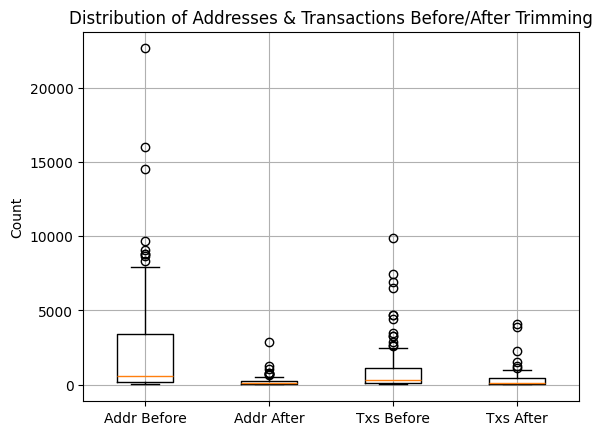

In [7]:
data = [addrs, trim_addrs, txs, trim_txs]

plt.boxplot(data, labels=['Addr Before', 'Addr After', 'Txs Before', 'Txs After'])
plt.title('Distribution of Addresses & Transactions Before/After Trimming')
plt.ylabel('Count')
plt.grid(True)
plt.savefig('box_plot.png', format='png', dpi = 1000)

plt.show()

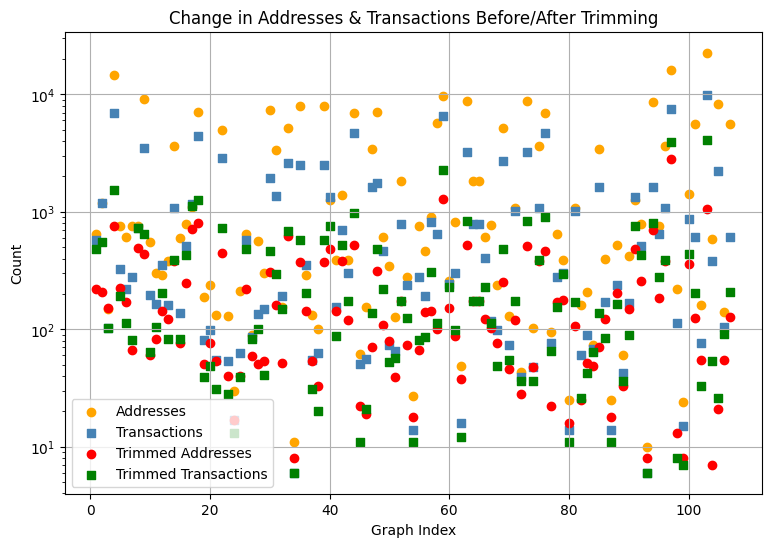

In [35]:
plt.figure(figsize=(9, 6))
num_graphs = 107
plt.scatter(range(1, num_graphs + 1), addrs, label='Addresses', color='orange', marker='o')
plt.scatter(range(1, num_graphs + 1), txs, label='Transactions',color='steelblue', marker='s')
plt.scatter(range(1, num_graphs + 1), trim_addrs, label='Trimmed Addresses', marker='o', color='red')
plt.scatter(range(1, num_graphs + 1), trim_txs, label='Trimmed Transactions', marker='s', color='green')
plt.legend()
plt.xlabel('Graph Index')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Change in Addresses & Transactions Before/After Trimming')
plt.grid(True)
plt.savefig('nodes_scatter_log.pdf', format='pdf', dpi=1000)
plt.show()

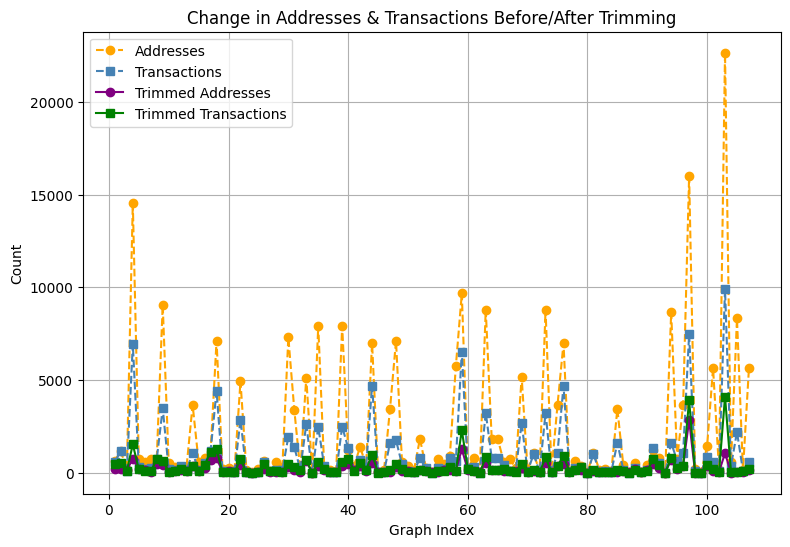

In [6]:
plt.figure(figsize=(9, 6))

num_graphs = 107
plt.plot(range(1, num_graphs + 1), addrs, label='Addresses', marker='o', linestyle='dashed', color='orange')
plt.plot(range(1, num_graphs + 1), txs, label='Transactions', marker='s', linestyle='dashed', color='steelblue')

plt.plot(range(1, num_graphs + 1), trim_addrs, label='Trimmed Addresses', marker='o', color='purple')
plt.plot(range(1, num_graphs + 1), trim_txs, label='Trimmed Transactions', marker='s', color='green')

plt.xlabel('Graph Index')
plt.ylabel('Count')
plt.title('Change in Addresses & Transactions Before/After Trimming')
plt.legend()
plt.grid(True)

plt.savefig('line_plot.png', format='png', dpi=1000)

plt.show()

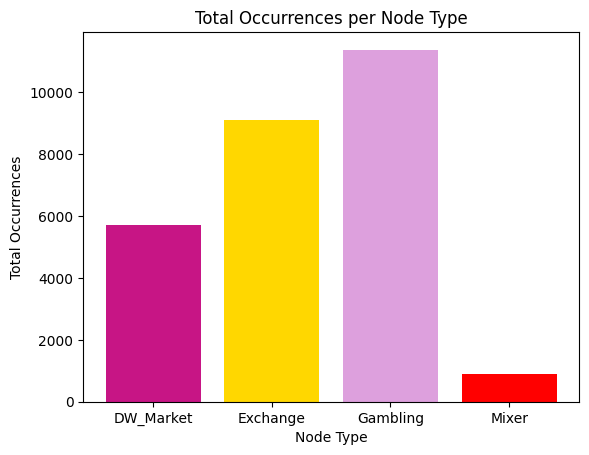

In [62]:
node_types = list(occurrences.keys())
totals = [np.sum(occurrences[t]) for t in node_types]

plt.bar(node_types, totals, color=['mediumvioletred', 'gold', 'plum', 'red'])
plt.xlabel("Node Type")
plt.ylabel("Total Occurrences")
plt.title("Total Occurrences per Node Type")
plt.savefig("occurrences.png", format='png', dpi=1000)
plt.show()

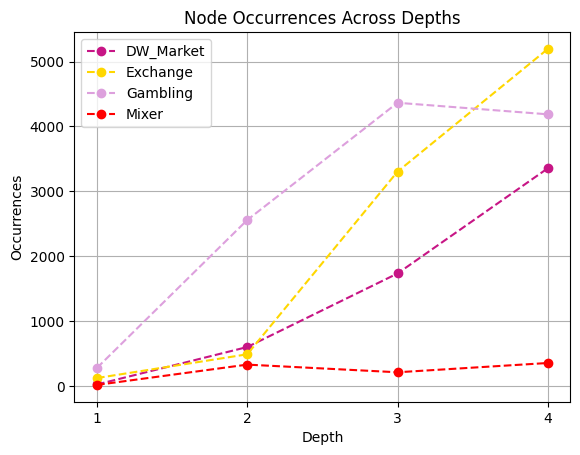

In [63]:
depths = [1,2,3,4]

colors = ['mediumvioletred', 'gold', 'plum', 'red']

for i, (node, occ) in enumerate(occurrences.items()):
    plt.plot(depths, occ, marker='o', linestyle='dashed', color=colors[i % len(colors)], label=node)

plt.xlabel("Depth")
plt.ylabel("Occurrences")
plt.title("Node Occurrences Across Depths")
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.savefig("occurrences_distr.png", format='png', dpi=1000)
plt.show()

In [12]:
tot_nodes = []
for i in range (len(launder_times)):
    tot_nodes.append(trim_addrs[i] + trim_txs[i])

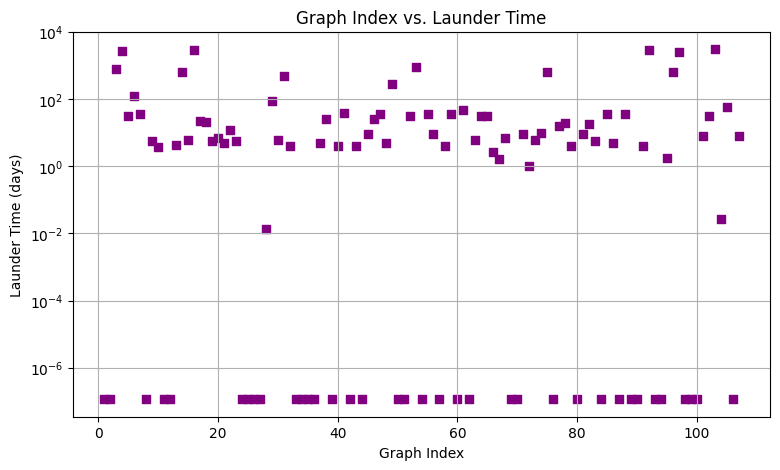

In [49]:
plt.figure(figsize=(9, 5))
scaled_launder = [(x+0.01)/86400 for x in launder_times]
num_graphs = 107
plt.scatter(range(1, num_graphs + 1), scaled_launder, marker='s', color='purple')
plt.xlabel('Graph Index')
plt.ylabel("Launder Time (days)")
plt.yscale('log')
plt.title("Graph Index vs. Launder Time")
plt.grid(True)
#plt.savefig('launder_scatter_log.png', format='png', dpi=1000)
plt.show()

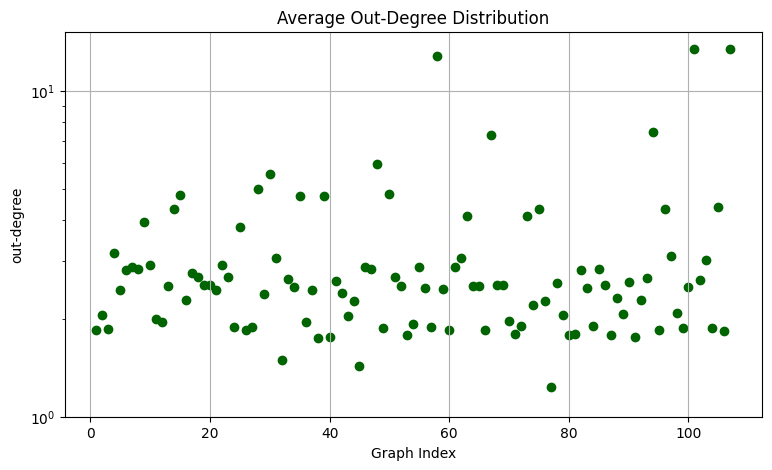

In [23]:
plt.figure(figsize=(9, 5))
num_graphs = 107
plt.scatter(range(1, num_graphs + 1), out_degs, marker='o', linestyle='-', color='darkgreen')

plt.xlabel("Graph Index")
plt.ylabel("out-degree")
plt.yscale('log')
plt.yticks([10**0, 10**1], [r"$10^0$", r"$10^1$"])
plt.title("Average Out-Degree Distribution")
plt.grid(True)
plt.savefig("outdeg_scatter_log.pdf", format='pdf', dpi=1000)
plt.show()

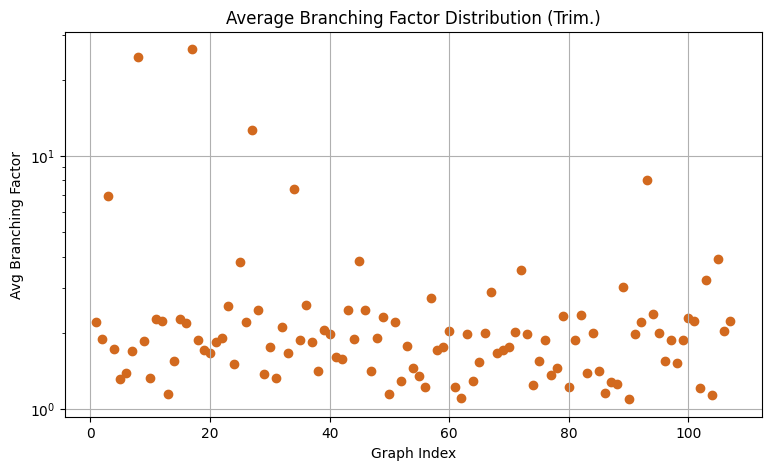

In [30]:
plt.figure(figsize=(9, 5))
num_graphs = 107
plt.scatter(range(1, num_graphs + 1), branchings, marker='o', linestyle='-', color='chocolate')

plt.xlabel("Graph Index")
plt.ylabel("Avg Branching Factor")
plt.yscale('log')
plt.title("Average Branching Factor Distribution (Trim.)")
plt.grid(True)
plt.savefig("branching_scatter_log.pdf", format='pdf', dpi=1000)
plt.show()

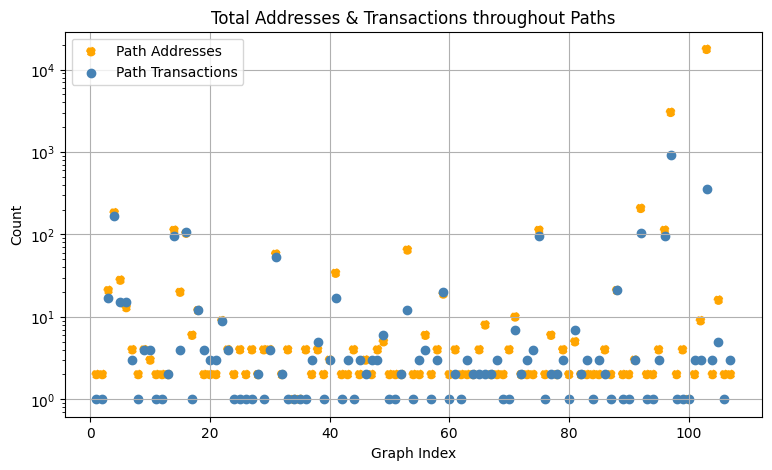

In [25]:
plt.figure(figsize=(9, 5))
num_graphs = 107

plt.scatter(range(1, num_graphs + 1), path_addrs, label='Path Addresses', marker='o', linestyle='dashed', color='orange')
plt.scatter(range(1, num_graphs + 1), path_txs, label='Path Transactions', marker='o', color='steelblue')


plt.xlabel('Graph Index')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Total Addresses & Transactions throughout Paths')
plt.legend()
plt.grid(True)

plt.savefig('path_line_scatter_log.png', format='png', dpi=1000)

plt.show()

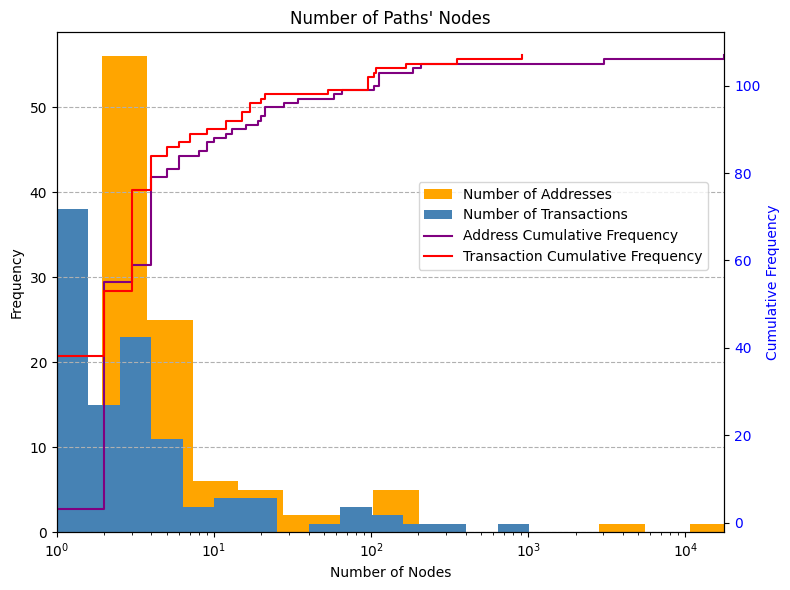

In [93]:
unique_nodi, counts = np.unique(path_addrs, return_counts=True)
unique_txs, tx_counts = np.unique(path_txs, return_counts=True)

min_addr = min(path_addrs)
max_addr = max(path_addrs)
min_tx = min(path_txs)
max_tx = max(path_txs)

addrs_bins_log = np.logspace(np.log(min_addr), np.log(max_addr), num=35)
txs_bins_log = np.logspace(np.log(min_tx), np.log(max_tx), num=35)

frequenza_cumulativa = np.cumsum(counts)
tx_cumulative = np.cumsum(tx_counts)


fig, ax1 = plt.subplots(figsize=(8, 6))
plt.title('Number of Paths\' Nodes')

ax1.set_xlim(min(min_addr, min_tx), max(max_addr, max_tx))
ax1.hist(path_addrs, bins = addrs_bins_log, color='orange', label = 'Number of Addresses')
ax1.hist(path_txs, bins = txs_bins_log, color='steelblue', label = 'Number of Transactions')
#df['trim_addrs'].plot.hist(bins=bins_log, color='#f1a340')
ax1.grid(True, axis = 'y', linestyle = '--')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Nodes')
ax1.set_ylabel('Frequency')


ax2 = ax1.twinx()
ax2.set_xscale('log')
ax2.step(unique_nodi, frequenza_cumulativa, color='purple', where='post', label="Address Cumulative Frequency")
ax2.step(unique_txs, tx_cumulative, color='red', where='post', label="Transaction Cumulative Frequency")
ax2.set_ylabel("Cumulative Frequency", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


fig.tight_layout()
fig.legend(loc=1, bbox_to_anchor=(0.4, 0., 0.5, 0.7))
plt.savefig('log_path_cumul.png', dpi=300)

plt.show()

In [44]:
mean_addr = sum(addrs)/107
mean_tx = sum(txs)/107
mean_rels = sum(rels)/107

mean_trim_tx = sum(trim_txs)/107
mean_trim_addr = sum(trim_addrs)/107
mean_trim_rels = sum(trim_rels)/107

In [45]:
print(f"Mean addrs|trim: {mean_addr}|{mean_trim_addr}, Mean txs|trim: {mean_tx}|{mean_trim_tx}")

Mean addrs|trim: 2335.2056074766356|225.52336448598132, Mean txs|trim: 1020.7289719626168|349.4859813084112


In [46]:
from scipy.stats import skew

def compute_skew_based_weights(data, skew_value):
    # Calculate inverse of skewness for weights
    if skew_value == 0:  # In case the skewness is zero
        skew_value = 1e-10  # Avoid division by zero

    # The weight is inversely proportional to the skewness
    # More skew (higher outliers) = lower weight, less skew = higher weight
    weights = 1 / np.abs(data - np.mean(data) + skew_value)
    weights = weights / weights.sum()  # Normalize the weights to sum to 1
    return weights

addrs_skewness = skew(addrs)
addrs_weights = compute_skew_based_weights(addrs, addrs_skewness)
addrs_weighted_mean = np.sum(addrs * addrs_weights)

txs_skewness = skew(txs)
txs_weights = compute_skew_based_weights(txs, txs_skewness)
txs_weighted_mean = np.sum(txs * txs_weights)

rels_skewness = skew(rels)
rels_weights = compute_skew_based_weights(rels, rels_skewness)
rels_weighted_mean = np.sum(rels * rels_weights)

trim_addrs_skewness = skew(trim_addrs)
trim_addrs_weights = compute_skew_based_weights(trim_addrs, trim_addrs_skewness)
trim_addrs_weighted_mean = np.sum(trim_addrs * trim_addrs_weights)

trim_txs_skewness = skew(trim_txs)
trim_txs_weights = compute_skew_based_weights(trim_txs, trim_txs_skewness)
trim_txs_weighted_mean = np.sum(trim_txs * trim_txs_weights)

trim_rels_skewness = skew(trim_rels)
trim_rels_weights = compute_skew_based_weights(trim_rels, trim_rels_skewness)
trim_rels_weighted_mean = np.sum(trim_rels * trim_rels_weights)

path_addrs_skewness = skew(path_addrs)
path_addrs_weights = compute_skew_based_weights(path_addrs, path_addrs_skewness)
path_addrs_weighted_mean = np.sum(path_addrs * path_addrs_weights)

path_txs_skewness = skew(path_txs)
path_txs_weights = compute_skew_based_weights(path_txs, path_txs_skewness)
path_txs_weighted_mean = np.sum(path_txs * path_txs_weights)


# Output the results
print(f"Addrs mean: {addrs_weighted_mean} skew: {addrs_skewness} | Txs mean: {txs_weighted_mean} skew: {txs_skewness}")
print(f"Trim Addrs mean: {trim_addrs_weighted_mean} skew: {trim_addrs_skewness} | Trim Txs mean: {trim_txs_weighted_mean} skew: {trim_txs_skewness}")
print(f"Rels mean: {rels_weighted_mean} skew: {rels_skewness} | Trim Rels mean: {trim_rels_weighted_mean} skew: {trim_rels_skewness}")
print(f"Path Addrs mean: {path_addrs_weighted_mean} skew: {path_addrs_skewness} | Path Txs mean: {path_txs_weighted_mean} skew: {path_txs_skewness}")

Addrs mean: 1448.2725032077042 skew: 2.574606995581494 | Txs mean: 903.358146680214 skew: 2.8781433288519316
Trim Addrs mean: 200.8927457050142 skew: 4.756194036600705 | Trim Txs mean: 271.27921644932115 skew: 4.253478661293143
Rels mean: 36577.661393347604 skew: 2.3608546867681035 | Trim Rels mean: 1823.3019611976574 skew: 6.350422488459097
Path Addrs mean: 59.78854844993128 skew: 9.80002024450609 | Path Txs mean: 7.393838809244914 skew: 7.849723259861372


### Cestino

Path lenght: record['pathLength']
Address label: list(record['lastNode'].labels)[0/1]